In [12]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Reshape,MaxPooling2D, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical

In [24]:
import os

paths = []
labels = []

# Define the root directory
real_root_dir = '/Users/desperate/Downloads/LJSpeech-1.1/wavs'
fake_root_dir = '/Users/desperate/Downloads/generated_audio/ljspeech_melgan'
# Iterate through the subdirectories
for filename in os.listdir(real_root_dir):
    file_path = os.path.join(real_root_dir, filename)
    paths.append(file_path)
    # Add label based on the subdirectory name
    labels.append('real')
    
for filename in os.listdir(fake_root_dir):
    file_path = os.path.join(fake_root_dir, filename)
    paths.append(file_path)
    # Add label based on the subdirectory name
    labels.append('fake')

print('Dataset is loaded')

Dataset is loaded


In [26]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

In [28]:
real_audio = '/Users/desperate/Downloads/LJSpeech-1.1/wavs/LJ001-0001.wav'
fake_audio = '/Users/desperate/Downloads/generated_audio/ljspeech_melgan/LJ001-0001_gen.wav'

In [30]:
def extract_features(fake_root_dir, real_root_dir, max_length=500):
    features = []
    labels = []
    
    for file in os.listdir(fake_root_dir):
        file_path = os.path.join(fake_root_dir, file)
        try:
            # Load audio file
            audio, _ = librosa.load(file_path, sr=16000)
            # Extract features (example: using Mel-Frequency Cepstral Coefficients)
            mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
            # Pad or trim the feature array to a fixed length
            if mfccs.shape[1] < max_length:
                mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
            else:
                mfccs = mfccs[:, :max_length]
            features.append(mfccs)
            # Assign label
            labels.append(1)  # 1 for fake
            
        except Exception as e:
            print(f"Error encountered while parsing file: {file_path}")
            continue
            
    for file in os.listdir(real_root_dir):
        file_path = os.path.join(real_root_dir, file)
        try:
            # Load audio file
            audio, _ = librosa.load(file_path, sr=16000)
            # Extract features (example: using Mel-Frequency Cepstral Coefficients)
            mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
            # Pad or trim the feature array to a fixed length
            if mfccs.shape[1] < max_length:
                mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
            else:
                mfccs = mfccs[:, :max_length]
            features.append(mfccs)
            # Assign label
            labels.append(0)  # 0 for real
        except Exception as e:
            print(f"Error encountered while parsing file: {file_path}")
            continue
    return np.array(features), np.array(labels)

# Example usage

x, y = extract_features(fake_root_dir, real_root_dir)

print("Features shape:", x.shape)
print("Labels shape:", y.shape)

Features shape: (26200, 40, 500)
Labels shape: (26200,)


In [33]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = .2)

In [35]:
import os

directory = '/Users/desperate/Desktop/FingerprintAndVoiceRecognition/src/dataset'
for root, dirs, files in os.walk(directory):
    print(root)
    for file in files:
        print(f'File: {file}')

/Users/desperate/Desktop/FingerprintAndVoiceRecognition/src/dataset
File: updated_model.h5


In [37]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential, regularizers

def create_model(input_shape=(40, 500, 1)):
    model = Sequential([
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Reshape((-1, 128)),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
        layers.BatchNormalization(),
        layers.Bidirectional(layers.LSTM(128, dropout=0.3, recurrent_dropout=0.2)),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [39]:
import tensorflow as tf
model = create_model()
model_path = '/Users/desperate/Desktop/FingerprintAndVoiceRecognition/src/dataset/updated_model.h5'
model.load_weights(model_path)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [41]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score

# Assuming your model is already defined
# X_train, y_train, X_test, y_test are your data and true labels

num_rounds = 2  # Number of rounds
results = []  # Store results for each round

for round_num in range(1, num_rounds + 1):
    print(f"Round {round_num}:")
    
    # Train your model (assuming it's a scikit-learn model)
    model.fit(xtrain, ytrain)
    
    # Make predictions
    y_pred = model.predict(xtest)
    y_pred = (y_pred > 0.5).astype(int)  # Threshold the output to get binary class (0 or 1)

    # Calculate precision, recall, and accuracy
    precision = precision_score(ytest, y_pred)
    recall = recall_score(ytest, y_pred)
    accuracy = accuracy_score(ytest, y_pred)

    # Print the metrics for the current round
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(ytest, y_pred)
    print("Confusion Matrix:")
    print(cm)
    
    # Save results
    results.append({
        "round": round_num,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "confusion_matrix": cm
    })

# Summary
print("\nSummary of 2 Rounds:")
for result in results:
    print(f"Round {result['round']}: Accuracy: {result['accuracy']:.4f}, Precision: {result['precision']:.4f}, Recall: {result['recall']:.4f}")

Round 1:
655/655 ━━━━━━━━━━━━━━━━━━━━ 470s 714ms/step - accuracy: 0.9733 - loss: 0.0940
164/164 ━━━━━━━━━━━━━━━━━━━━ 27s 164ms/step
Accuracy: 0.9868
Precision: 0.9799
Recall: 0.9943
Confusion Matrix:
[[2540   54]
 [  15 2631]]
Round 2:
655/655 ━━━━━━━━━━━━━━━━━━━━ 542s 827ms/step - accuracy: 0.9801 - loss: 0.0711
164/164 ━━━━━━━━━━━━━━━━━━━━ 29s 175ms/step
Accuracy: 0.9683
Precision: 0.9662
Recall: 0.9713
Confusion Matrix:
[[2504   90]
 [  76 2570]]

Summary of 2 Rounds:
Round 1: Accuracy: 0.9868, Precision: 0.9799, Recall: 0.9943
Round 2: Accuracy: 0.9683, Precision: 0.9662, Recall: 0.9713


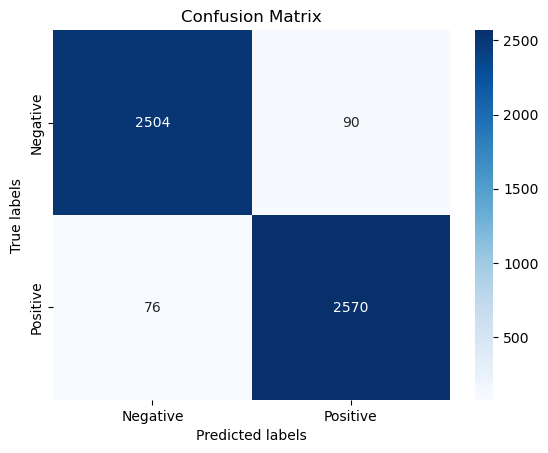

In [43]:
# You can also plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.title('Confusion Matrix')
plt.show()